# ML

## Blind Source Separation

Blind Source Separation is the separation of a set of source signals from a set of mixed signals.

My favorite example of this problem is known as the cocktail party problem where a number of people are talking simultaneously and we want to separate each persons speech so we can listen to it separately. Now the caveat with this type of approach is that we need as many mixtures as we have source signals or in terms of the cocktail party problem we need as many microphones as people talking in the room.

Let’s get started. This example is going to be in Python and the first thing we are going to need to do is load some audio files. To make things a bit easier further on in this example I’m going to wrap the basic scipy wav file reader and add some additional functionality. First I added a case to handle converting stereo wav files back into mono wav files and secondly this loader takes a desired sample rate and resamples the input to match. This is important because when we mix the two audio signals they need to have the same sample rate.

In [1]:
!pip install git+git://github.com/mariolpantunes/nmf@main#egg=nmf

  Cloning git://github.com/mariolpantunes/nmf (to revision main) to /tmp/pip-install-0h75tyf6/nmf_60a476b14bc14cc9b615d833b9ba0b85
  Running command git clone -q git://github.com/mariolpantunes/nmf /tmp/pip-install-0h75tyf6/nmf_60a476b14bc14cc9b615d833b9ba0b85
     |████████████████████████████████| 15.7 MB 10.2 MB/s 
  Created wheel for nmf: filename=nmf-0.1-py3-none-any.whl size=3482 sha256=c59671607241f73c2862031e7ca544c2c4c93e1de04238dc446cf50b5e2771a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-e06ddkea/wheels/40/b9/d6/aefe4b25f7400944416d36e0b6a7989bf9ef96d70e516805d3
Successfully built nmf
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have

In [4]:
import os
from scipy.io import wavfile
from scipy.signal import resample
from urllib import request
from urllib.parse import urlparse

# Download a wave audio files and read the same 
def load_wav_url(remote_url, samplerate=44100):
  local_file = '/tmp/'+os.path.basename(urlparse(remote_url).path)
  # download file to TMP
  request.urlretrieve(remote_url, local_file)
  print(f'Local File: '+local_file)

  return load_wav(local_file, samplerate)

# Reads an wave audio file
def load_wav(filename, samplerate=44100):

    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, int(len(data) * ratio))

    return samplerate, data.astype(np.int16)

Next we’re going to need a way to play the audio files we’re working with (otherwise this wouldn’t be very exciting at all would it?). In the next bit of code I’ve defined a wavPlayer class that takes the signal and the sample rate and then creates a nice HTML5 webplayer right inline with the notebook.

In [5]:
from IPython.display import display, Audio 


def wav_player(data, rate):
  local_file = '/tmp/sample.wav'
  wavfile.write(local_file, rate, data)
  display(Audio(local_file, autoplay=False))

Now that we can load and play wav files we actually need some wav files! I found the sounds from Starcraft to be a great source of wav files because they’re short, interesting and remind me of my childhood. You can download Starcraft wav files here: http://wavs.unclebubby.com/computer/starcraft/ among other places on the web or from your Starcraft install directory (come on I know it’s still there).

Another good source of data (although lets be honest less cool) is ICA central and various other more academic data sets: http://perso.telecom-paristech.fr/~cardoso/icacentral/base_multi.html. Note that for lots of these data sets the data will be mixed already so you’ll be able to skip the next few steps.

Okay lets load up an audio file. I chose the Terran Battlecruiser saying “Good Day Commander”. In addition to the creating a wavPlayer I also plotted the data using Matplotlib (and tried my best to have the graph length match the HTML player length). Have a listen!

Populating the interactive namespace from numpy and matplotlib
Local File: /tmp/audio1.wav


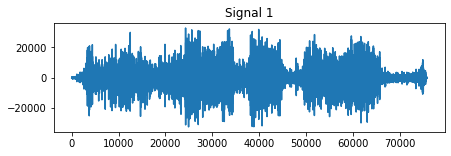

In [6]:
%pylab inline
import pylab as pl
import numpy as np

audio01='https://mscipio.github.io/data/posts/audio1.wav'

# load
fs1,s1 = load_wav_url(audio01) # Terran Marine - "You want a piece of me, boy?"

# plot
pl.figure(figsize=(7,2))
pl.plot(s1)
pl.title('Signal 1')
pl.show()

# player
wav_player(s1, fs1)

Now let’s load a second audio clip:

Local File: /tmp/audio2.wav


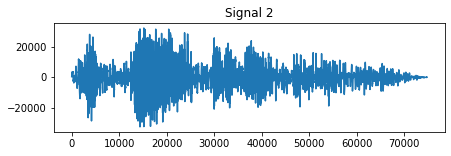

In [7]:
audio02='https://mscipio.github.io/data/posts/audio2.wav'

# load
fs2,s2 = load_wav_url(audio02) # Terran Battlecruiser - "Good day, commander."

# plot
pl.figure(figsize=(7,2))
pl.plot(s2)
pl.title('Signal 2')
pl.show()

# player
wav_player(s2, fs2)


and a third audio clip:

Local File: /tmp/audio3.wav


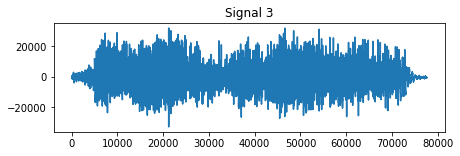

In [8]:
audio03='https://mscipio.github.io/data/posts/audio3.wav'

# load
fs3,s3 = load_wav_url(audio03) # Protoss Zealot - "My life for Aiur!"

# plot
pl.figure(figsize=(7,2))
pl.plot(s3)
pl.title('Signal 3')
pl.show()

# player
wav_player(s3, fs3)

Now we’ve got our audio files loaded up into our example program. The next thing we need to do is mix them together!

First another nuance - what if the audio clips aren’t the same lenth? The solution I came up with for this was to simply resize them all to the length of the longest signal, the extra length will just be filled with zeros so it won’t affect the sound.

The signals are mixed by creating a mixing matrix $A$
and taking the dot product of $A$ with the signals $S$.

Afterwards I plot the mixed signals and create the wavPlayers, have a listen!

Mixing Matrix:
[[1.  0.5 0.5]
 [0.5 1.  0.5]
 [0.5 0.5 1. ]]


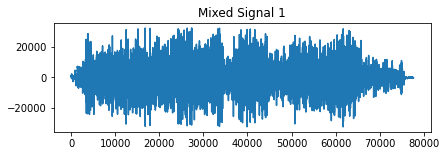

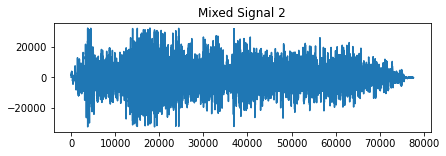

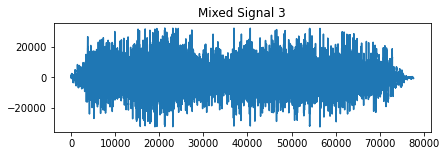

In [9]:
# Adjust for different clip lengths
fs = fs1
length = max([len(s1), len(s2), len(s3)])

s1.resize((length,1), refcheck=False)
s2.resize((length,1), refcheck=False)
s3.resize((length,1), refcheck=False)

"""
The function numpy.c_ concatenates the numpy arrays given as input.
The method numpy_array.T is the transpose operation that allow us
to prepare an input source matrix of the right size (3, length),
according to the chosen mixing matrix (3,3).
"""
S = (np.c_[s1, s2, s3]).T

# Mixing Matrix
#A = np.random.uniform(size=(3,3))
#A = A / A.sum(axis=0)
A = np.array([[1, 0.5, 0.5],
              [0.5, 1, 0.5],
              [0.5, 0.5, 1]])
print('Mixing Matrix:')
print(A.round(2))

# Mixed Signals
X = np.dot(A,S)

# Exploring Mixed Signals
for i in range(X.shape[0]):
    pl.figure(figsize=(6.75,2))
    pl.plot((X[i]).astype(np.int16))
    pl.title('Mixed Signal %d' % (i+1))
    pl.show()
    wav_player((X[i]).astype(np.int16), fs)

## FastICA

In [10]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3, random_state=42)
S_ = ica.fit_transform(X.T).T  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print(f'{X.shape}/{S_.shape}')
print(A_)

(3, 77636)/(3, 77636)
[[ -739710.19437301 -1738281.34062602 -1092688.89038471]
 [-1577972.65597671  -893947.23501757 -1129692.3251847 ]
 [ -705107.756998    -867721.65797178 -2156290.68382371]]


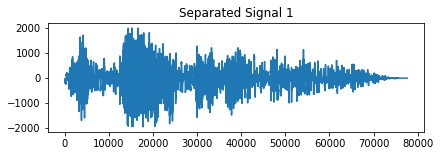

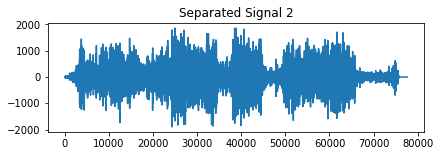

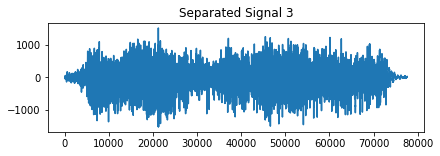

In [11]:
# Show separation results

# Separated Signal i
gain = 100000
for i in range(S_.shape[0]):
    pl.figure(figsize=(6.75,2))
    pl.plot((gain*S_[i]).astype(np.int16))
    pl.title('Separated Signal %d' % (i+1))
    pl.show()
    wav_player((gain*S_[i]).astype(np.int16), fs)

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
H = pca.fit_transform(X.T).T

print(f'{X.shape}/{H.shape}')

(3, 77636)/(3, 77636)


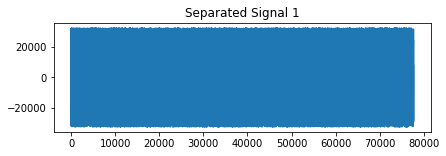

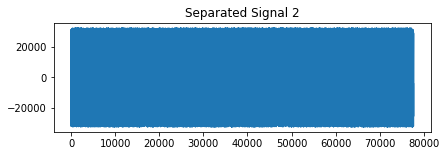

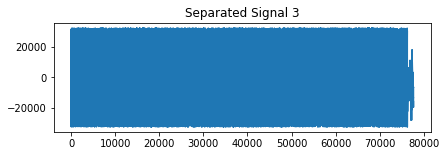

In [24]:
# Show separation results

# Separated Signal i
gain = 1000
for i in range(H.shape[0]):
    pl.figure(figsize=(6.75,2))
    pl.plot((gain*H[i]).astype(np.int16))
    pl.title('Separated Signal %d' % (i+1))
    pl.show()
    wav_player((gain*H[i]).astype(np.int16), fs)

## NMF


In [14]:
from nmf.nmf import nmf_mu

Xr, W, H, cost = nmf_mu(X, k=3, seed=42)

print(f'{X.shape}/{H.shape}')

/usr/local/lib/python3.7/dist-packages/nmf/nmf.py:105: RuntimeWarning: divide by zero encountered in true_divide
  H = np.multiply(H, np.divide(W.T@(M*X)-l*np.linalg.norm(H, 'fro'), W.T@(M*(W@H))))


(3, 77636)/(3, 77636)


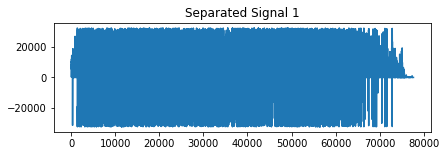

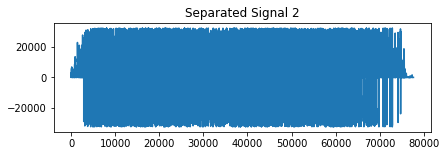

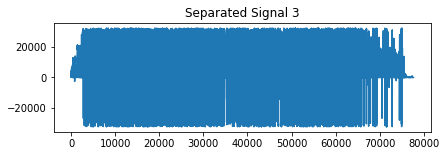

In [15]:
# Show separation results

# Separated Signal i
gain = 100000
for i in range(H.shape[0]):
    pl.figure(figsize=(6.75,2))
    pl.plot((gain*H[i]).astype(np.int16))
    pl.title('Separated Signal %d' % (i+1))
    pl.show()
    wav_player((gain*H[i]).astype(np.int16), fs)